# GIC YTD Premium Analysis Report (Apr 2025 – Oct 2025)

**Date:** December 19, 2025  
**Data Source:** General Insurance Council (Monthly Segment Reports)  
**Comparison:** FY24 vs. FY25


## 1. Setup and Library Imports

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Pipeline: Extraction, Transformation, Loading (ETL)
We process raw monthly Excel files, normalize column names, remove derived totals, and merge them into a single master dataset.

In [110]:
files = [
    "segment_april_2025 (1).xlsx", "segment_may_2025 (1).xlsx",
    "segment_june_2025 (1).xlsx", "segment_july_2025 (1).xlsx",
    "segment_august_2025 (1).xlsx", "segment_september_2025 (1).xlsx",
    "segment_october_2025 (1).xlsx",
]

all_data = []

try:
    for file in files:
        df = pd.read_excel(file)

        # 1. Rename company column
        df = df.rename(columns={"Unnamed: 0": "company"})

        # 2. Normalize Year column name
        if "Year" in df.columns:
            df = df.rename(columns={"Year": "year"})

        # 3. Clean column names
        df.columns = (
            df.columns
            .str.strip().str.lower()
            .str.replace(" ", "_")
            .str.replace(r"[()]", "", regex=True)
            .str.replace("+", "plus")
        )

        # 4. Split year column -> financial_year + ytd_upto_month
        df["financial_year"] = df["year"].str.slice(0, 4)
        df["ytd_upto_month"] = df["year"].str.slice(5)
        df = df.drop(columns=["year"])

        # 5. Drop derived total columns to prevent double counting
        drop_cols = [  "motor_od", "motor_tp",   "marine_cargo", "marine_hull"]
        df = df.drop(columns=[c for c in drop_cols if c in df.columns])

        # 6. Convert wide -> long
        id_cols = ["company", "financial_year", "ytd_upto_month"]
        value_cols = [c for c in df.columns if c not in id_cols]

        df_long = df.melt(
            id_vars=id_cols,
            value_vars=value_cols,
            var_name="segment",
            value_name="premium_ytd"
        )

        # 7. Keep only meaningful rows
        df_long = df_long[df_long["premium_ytd"] > 0]
        all_data.append(df_long)

    # 8. Merge all months
    final_df = pd.concat(all_data, ignore_index=True)

    # 9. Final segment name cleanup
    final_df["segment"] = (
        final_df["segment"]
        .str.replace("__", "_")
        .str.replace("p.a.", "personal_accident")
        .str.replace(
            "all_other_misc_crop_insurance_plus_credit_guaranteeplusall_other_misc",
            "misc"
        )
    )
    
    drop_segments = [
    "marine_cargo", "marine_hull",
    "motor_od", "motor_tp"
    ]

    final_df = final_df[~final_df["segment"].isin(drop_segments)]
    
    # Save for future use
    final_df.to_csv("gic_ytd_master_apr_oct.csv", index=False)
    print("Data loaded and processed successfully. Shape:", final_df.shape)
    
except Exception as e:
    print(f"Warning: Could not process raw files ({e}). Loading from CSV if available...")
    try:
        final_df = pd.read_csv("gic_ytd_master_apr_oct.csv")
        print("Loaded from CSV.")
    except:
        print("Error: No data available.")

Data loaded and processed successfully. Shape: (2919, 5)


In [111]:
final_df['segment'].value_counts()

segment
health               422
personal_accident    406
misc                 375
motor_total          336
liability            319
fire                 311
engineering          308
marine_total         298
aviation             144
Name: count, dtype: int64

## 3. Data Validation
Ensuring data integrity before analysis.

In [112]:
# 1. Null check
print("Null values:\n", final_df.isnull().sum())

# 2. Negative values check
print("\nNegative premium rows:", final_df[final_df["premium_ytd"] < 0].shape[0])

# 3. Segment Check
print("\nUnique Segments:", sorted(final_df["segment"].unique()))

Null values:
 company           0
financial_year    0
ytd_upto_month    0
segment           0
premium_ytd       0
dtype: int64

Negative premium rows: 0

Unique Segments: ['aviation', 'engineering', 'fire', 'health', 'liability', 'marine_total', 'misc', 'motor_total', 'personal_accident']


## 4. Industry Trend Analysis
Analyzing the overall market growth trajectory (FY24 vs FY25).

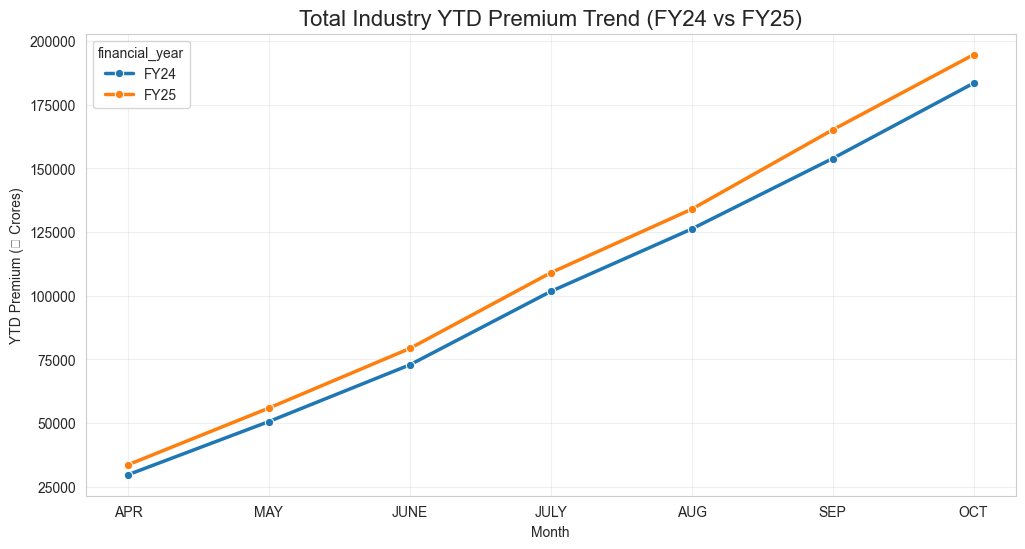

In [113]:
# Ensure chronological order
month_order = ["APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT"]
final_df["ytd_upto_month"] = pd.Categorical(final_df["ytd_upto_month"], categories=month_order, ordered=True)

# Aggregate Industry Total
industry_trend = (
    final_df.groupby(["financial_year", "ytd_upto_month"])["premium_ytd"]
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=industry_trend,
    x="ytd_upto_month",
    y="premium_ytd",
    hue="financial_year",
    marker="o",
    linewidth=2.5
)
plt.title("Total Industry YTD Premium Trend (FY24 vs FY25)", fontsize=16)
plt.ylabel("YTD Premium (₹ Crores)")
plt.xlabel("Month")
plt.grid(True, alpha=0.3)
plt.show()

In [114]:
month_order = ["APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT"]
final_df["ytd_upto_month"] = pd.Categorical(
    final_df["ytd_upto_month"], categories=month_order, ordered=True
)

industry_ytd = (
    final_df
    .groupby(["financial_year", "ytd_upto_month"])["premium_ytd"]
    .sum()
    .reset_index()
    .sort_values(["financial_year", "ytd_upto_month"])
)
industry_ytd["monthly_premium"] = (
    industry_ytd
    .groupby("financial_year")["premium_ytd"]
    .diff()
)

# APR = first month
industry_ytd.loc[industry_ytd["ytd_upto_month"] == "APR", "monthly_premium"] = (
    industry_ytd.loc[industry_ytd["ytd_upto_month"] == "APR", "premium_ytd"]
)

print(display(industry_ytd))


,financial_year,ytd_upto_month,premium_ytd,monthly_premium
0,FY24,APR,29682.48,29682.48
1,FY24,MAY,50587.20,20904.72
2,FY24,JUNE,72860.15,22272.95
3,FY24,JULY,101688.64,28828.49
4,FY24,AUG,126221.75,24533.11
5,FY24,SEP,153910.69,27688.94
6,FY24,OCT,183474.84,29564.15
7,FY25,APR,33599.35,33599.35
8,FY25,MAY,55887.60,22288.25
9,FY25,JUNE,79301.43,23413.83


None


In [115]:
mom_pivot = (
    industry_ytd
    .pivot(index="ytd_upto_month", columns="financial_year", values="monthly_premium")
)

mom_pivot["YoY_Monthly_Abs"] = mom_pivot["FY25"] - mom_pivot["FY24"]
mom_pivot["YoY_Monthly_Pct"] = (
    mom_pivot["YoY_Monthly_Abs"] / mom_pivot["FY24"] * 100
).round(2)

display(mom_pivot)


financial_year,FY24,FY25,YoY_Monthly_Abs,YoY_Monthly_Pct
ytd_upto_month,,,,
APR,29682.48,33599.35,3916.87,13.20
MAY,20904.72,22288.25,1383.53,6.62
JUNE,22272.95,23413.83,1140.88,5.12
JULY,28828.49,29729.27,900.78,3.12
AUG,24533.11,24958.44,425.33,1.73
SEP,27688.94,31168.13,3479.19,12.57
OCT,29564.15,29523.53,-40.62,-0.14


In [116]:
# Calculate YoY Growth
fy_trend = (
    industry_trend.pivot(index="ytd_upto_month", columns="financial_year", values="premium_ytd")
)
fy_trend["YoY_Growth_Abs"] = fy_trend["FY25"] - fy_trend["FY24"]
fy_trend["YoY_Growth_Pct"] = (fy_trend["YoY_Growth_Abs"] / fy_trend["FY24"] * 100).round(2)

display(fy_trend)

financial_year,FY24,FY25,YoY_Growth_Abs,YoY_Growth_Pct
ytd_upto_month,,,,
APR,29682.48,33599.35,3916.87,13.20
MAY,50587.20,55887.60,5300.40,10.48
JUNE,72860.15,79301.43,6441.28,8.84
JULY,101688.64,109030.70,7342.06,7.22
AUG,126221.75,133989.14,7767.39,6.15
SEP,153910.69,165157.27,11246.58,7.31
OCT,183474.84,194680.80,11205.96,6.11


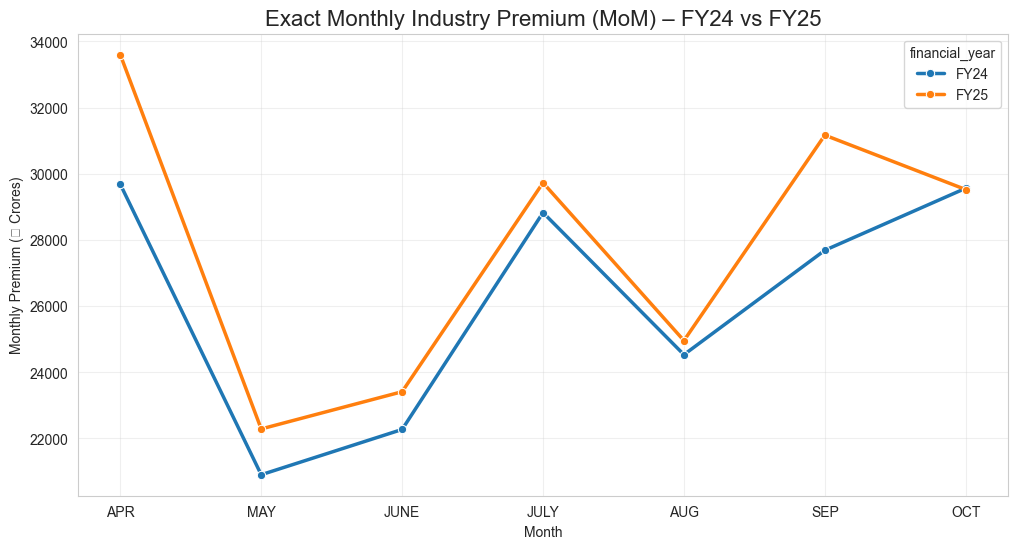

In [117]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=industry_ytd,
    x="ytd_upto_month",
    y="monthly_premium",
    hue="financial_year",
    marker="o",
    linewidth=2.5
)

plt.title("Exact Monthly Industry Premium (MoM) – FY24 vs FY25", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.show()


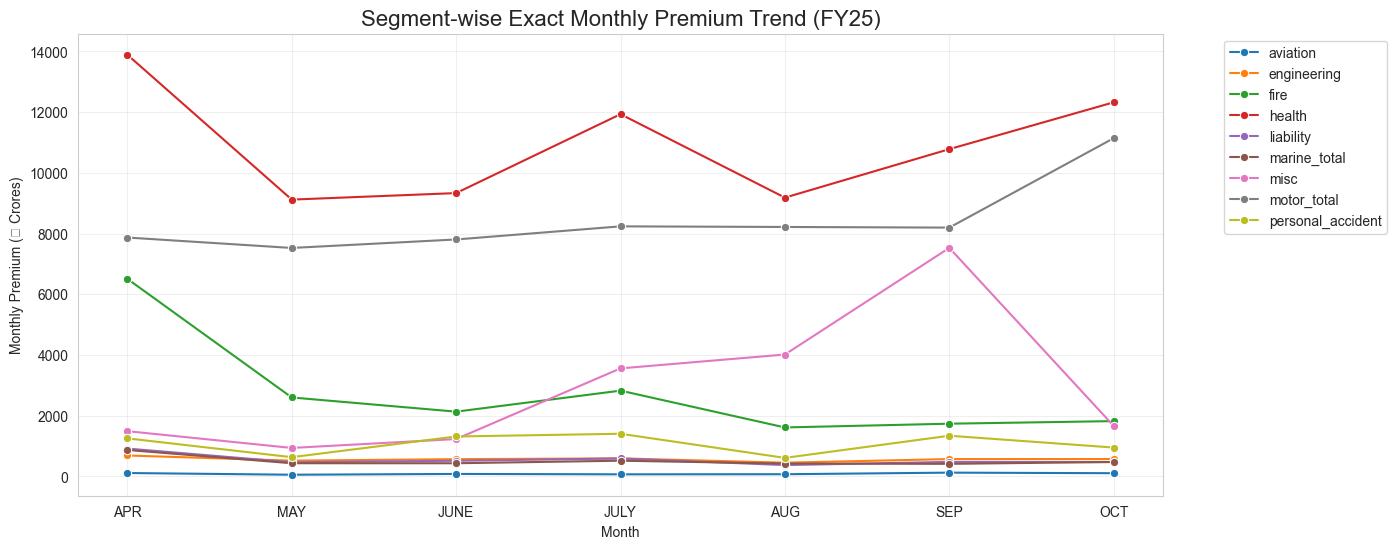

In [118]:
# Ensure correct order
month_order = ["APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT"]
final_df["ytd_upto_month"] = pd.Categorical(
    final_df["ytd_upto_month"],
    categories=month_order,
    ordered=True
)

# Aggregate YTD at segment level first
segment_ytd = (
    final_df
    .groupby(["financial_year", "segment", "ytd_upto_month"])["premium_ytd"]
    .sum()
    .reset_index()
    .sort_values(["financial_year", "segment", "ytd_upto_month"])
)

# Current − Previous month
segment_ytd["monthly_premium"] = (
    segment_ytd
    .groupby(["financial_year", "segment"])["premium_ytd"]
    .diff()
)

# APR = first month
segment_ytd.loc[segment_ytd["ytd_upto_month"] == "APR", "monthly_premium"] = (
    segment_ytd.loc[segment_ytd["ytd_upto_month"] == "APR", "premium_ytd"]
)
plt.figure(figsize=(14,6))
sns.lineplot(
    data=segment_ytd[segment_ytd["financial_year"] == "FY25"],
    x="ytd_upto_month",
    y="monthly_premium",
    hue="segment",
    marker="o"
)

plt.title("Segment-wise Exact Monthly Premium Trend (FY25)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


Bottom 4 segments: ['aviation', 'marine_total', 'liability', 'engineering']


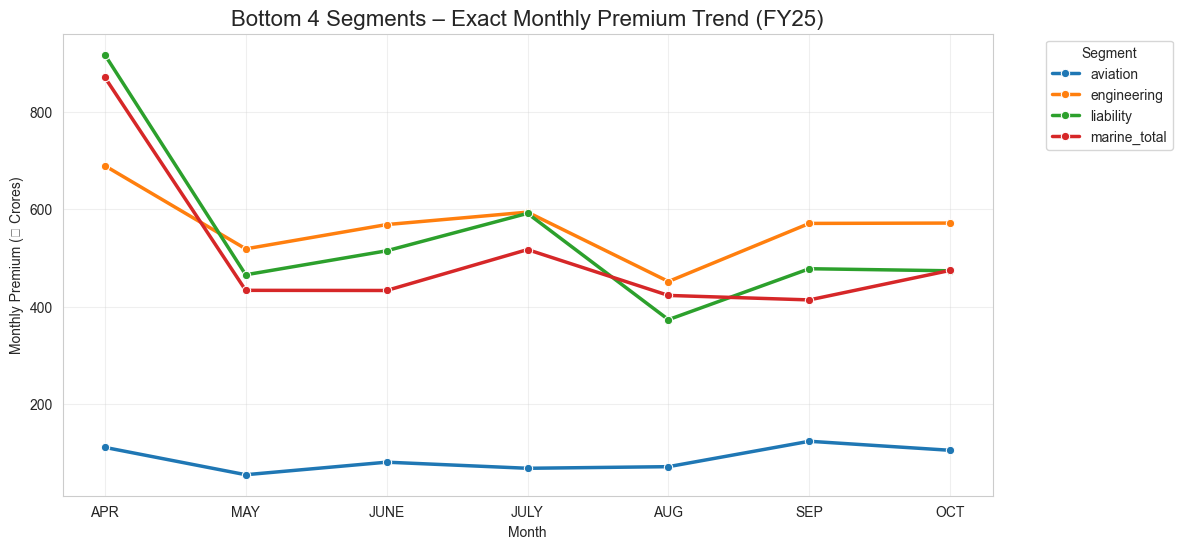

In [119]:
bottom_segments = (
    segment_ytd[segment_ytd["financial_year"] == "FY25"]
    .groupby("segment")["monthly_premium"]
    .sum()
    .sort_values()
    .head(4)
    .index
)

print("Bottom 4 segments:", list(bottom_segments))
# Added line break here - this was missing in the original code
bottom_seg_data = segment_ytd[ 
    (segment_ytd["financial_year"] == "FY25") & 
    (segment_ytd["segment"].isin(bottom_segments))
]

plt.figure(figsize=(12,6))

sns.lineplot(
    data=bottom_seg_data,
    x="ytd_upto_month",
    y="monthly_premium",
    hue="segment",
    marker="o",
    linewidth=2.5
)

plt.title("Bottom 4 Segments – Exact Monthly Premium Trend (FY25)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

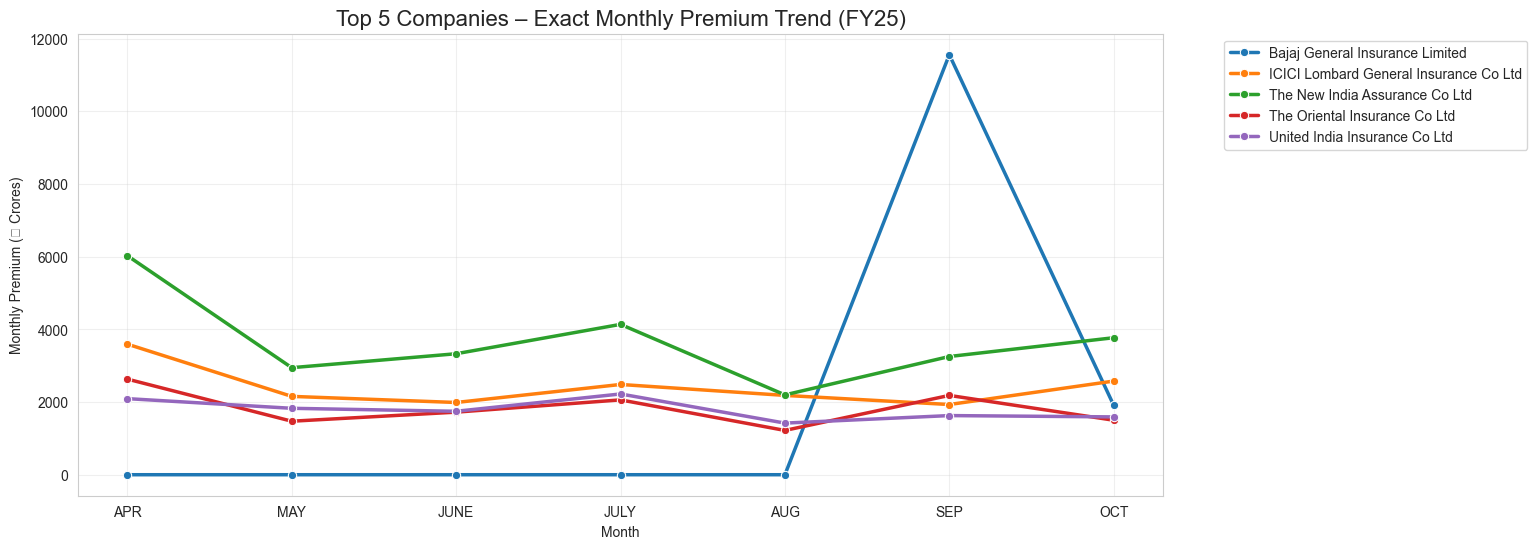

In [120]:
# Ensure month order
month_order = ["APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT"]
final_df["ytd_upto_month"] = pd.Categorical(
    final_df["ytd_upto_month"], categories=month_order, ordered=True
)

# Aggregate YTD at company level
company_ytd = (
    final_df
    .groupby(["financial_year", "company", "ytd_upto_month"])["premium_ytd"]
    .sum()
    .reset_index()
    .sort_values(["financial_year", "company", "ytd_upto_month"])
)

# Current − Previous month
company_ytd["monthly_premium"] = (
    company_ytd
    .groupby(["financial_year", "company"])["premium_ytd"]
    .diff()
)

# APR = first month
company_ytd.loc[
    company_ytd["ytd_upto_month"] == "APR",
    "monthly_premium"
] = company_ytd.loc[
    company_ytd["ytd_upto_month"] == "APR",
    "premium_ytd"
]
company_rank = (
    company_ytd[company_ytd["financial_year"] == "FY25"]
    .groupby("company")["monthly_premium"]
    .sum()
    .sort_values(ascending=False)
)

top_5_companies = company_rank.head(5).index
bottom_5_companies = company_rank.tail(5).index

top5_data = company_ytd[
    (company_ytd["financial_year"] == "FY25") &
    (company_ytd["company"].isin(top_5_companies))
]

plt.figure(figsize=(14,6))
sns.lineplot(
    data=top5_data,
    x="ytd_upto_month",
    y="monthly_premium",
    hue="company",
    marker="o",
    linewidth=2.5
)

plt.title("Top 5 Companies – Exact Monthly Premium Trend (FY25)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


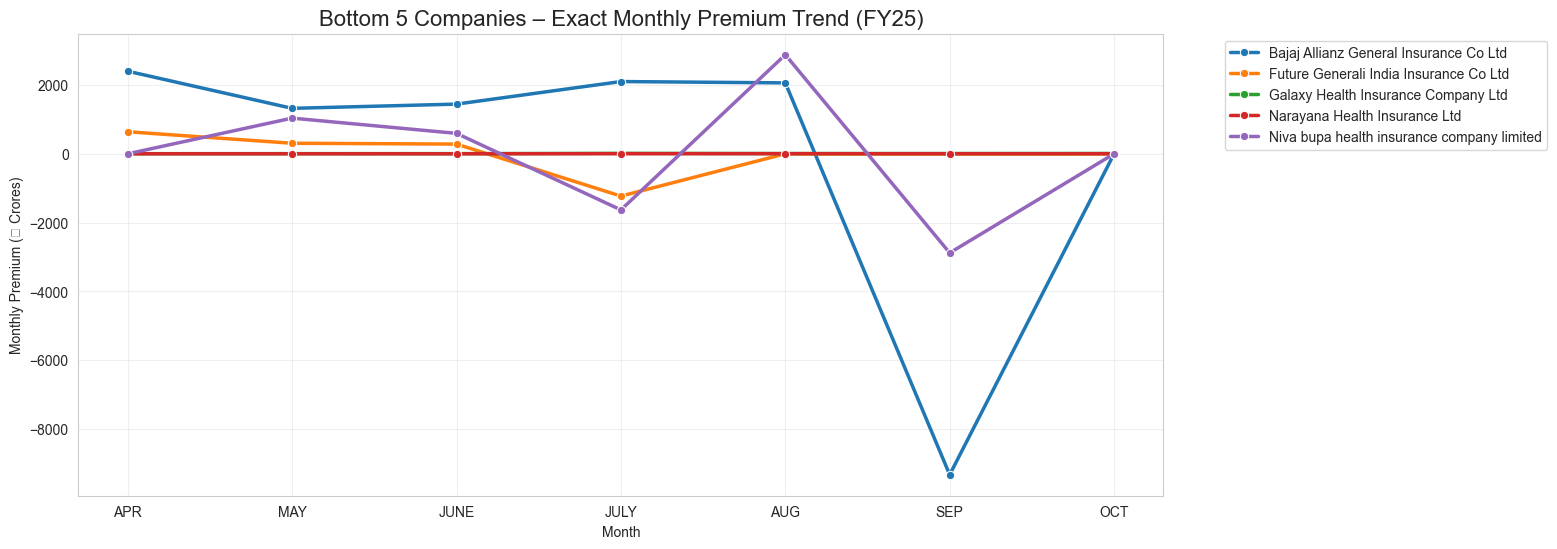

In [121]:
bottom5_data = company_ytd[
    (company_ytd["financial_year"] == "FY25") &
    (company_ytd["company"].isin(bottom_5_companies))
]

plt.figure(figsize=(14,6))
sns.lineplot(
    data=bottom5_data,
    x="ytd_upto_month",
    y="monthly_premium",
    hue="company",
    marker="o",
    linewidth=2.5
)

plt.title("Bottom 5 Companies – Exact Monthly Premium Trend (FY25)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


## 5. Segment Performance
Deep dive into specific business lines.

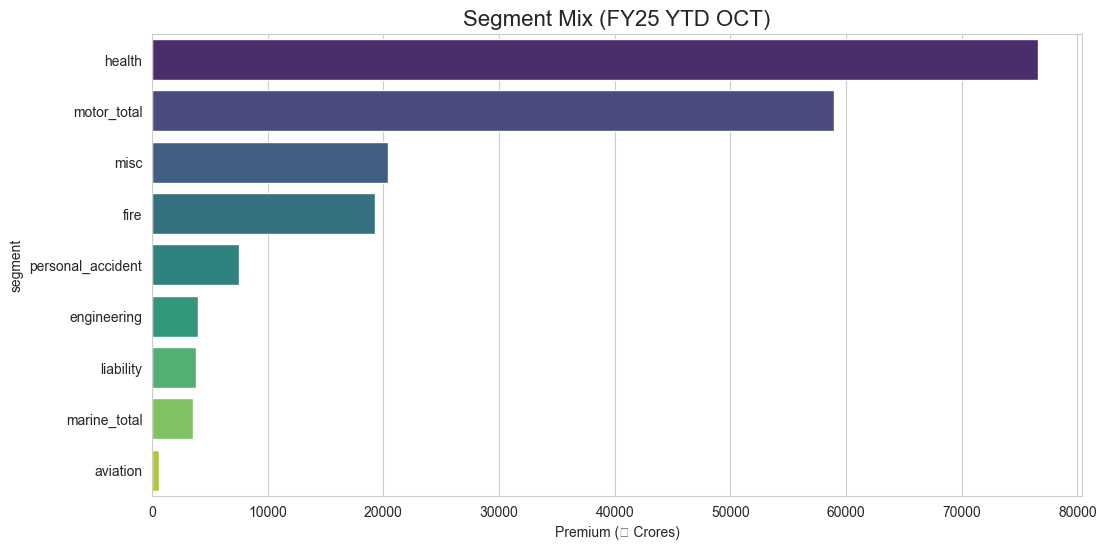

,segment,premium_ytd,Share
0,health,76564.07,39.33
1,motor_total,58992.83,30.30
2,misc,20421.84,10.49
3,fire,19237.43,9.88
4,personal_accident,7504.74,3.85
5,engineering,3963.90,2.04
6,liability,3812.98,1.96
7,marine_total,3565.73,1.83
8,aviation,617.28,0.32


In [122]:
# Filter for Latest Month (OCT) FY25
latest_segment_mix = final_df[
    (final_df["financial_year"] == "FY25") &
    (final_df["ytd_upto_month"] == "OCT")
].groupby("segment")["premium_ytd"].sum().sort_values(ascending=False).reset_index()

total_premium = latest_segment_mix["premium_ytd"].sum()
latest_segment_mix["Share"] = (latest_segment_mix["premium_ytd"] / total_premium * 100).round(2)

plt.figure(figsize=(12,6))
sns.barplot(data=latest_segment_mix, x="premium_ytd", y="segment", palette="viridis")
plt.title("Segment Mix (FY25 YTD OCT)", fontsize=16)
plt.xlabel("Premium (₹ Crores)")
plt.show()

display(latest_segment_mix)

### Segment Growth Attribution (FY25 vs FY24)

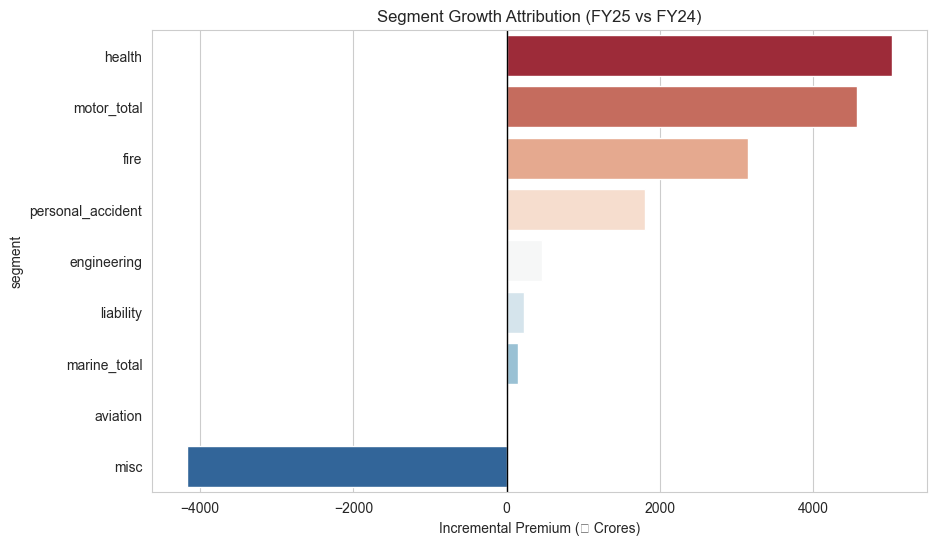

In [123]:
growth_seg = (
    final_df[final_df["ytd_upto_month"] == "OCT"]
    .groupby(["segment", "financial_year"])["premium_ytd"]
    .sum()
    .unstack(fill_value=0)
)

growth_seg["incremental"] = growth_seg["FY25"] - growth_seg["FY24"]
growth_seg = growth_seg.sort_values("incremental", ascending=False).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=growth_seg, x="incremental", y="segment", palette="RdBu")
plt.axvline(0, color="black", linewidth=1)
plt.title("Segment Growth Attribution (FY25 vs FY24)")
plt.xlabel("Incremental Premium (₹ Crores)")
plt.show()

Text(0, 0.5, 'Monthly Premium')

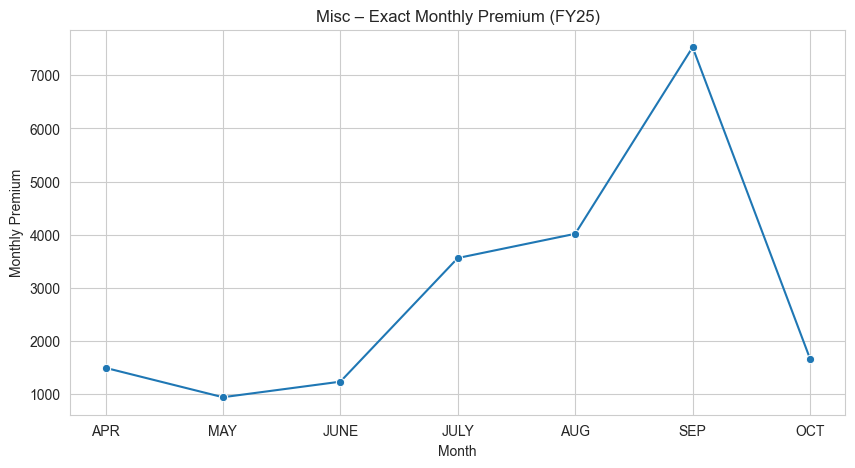

In [124]:
misc_monthly = (
    segment_ytd[
        (segment_ytd["financial_year"] == "FY25") &
        (segment_ytd["segment"] == "misc")
    ][["ytd_upto_month", "monthly_premium"]]
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=misc_monthly,
    x="ytd_upto_month",
    y="monthly_premium",
    marker="o"
)
plt.title("Misc – Exact Monthly Premium (FY25)")
plt.xlabel("Month")
plt.ylabel("Monthly Premium")  # Added closing quotation mark and completed the label

company
Agriculture Insurance Co Of India Ltd   7016.10
Reliance General Insurance Co Ltd       1781.26
Bajaj General Insurance Limited         1713.17
HDFC Ergo General Insurance Co Ltd      1257.87
SBI General Insurance Co Ltd            1243.67
Name: monthly_premium, dtype: float64

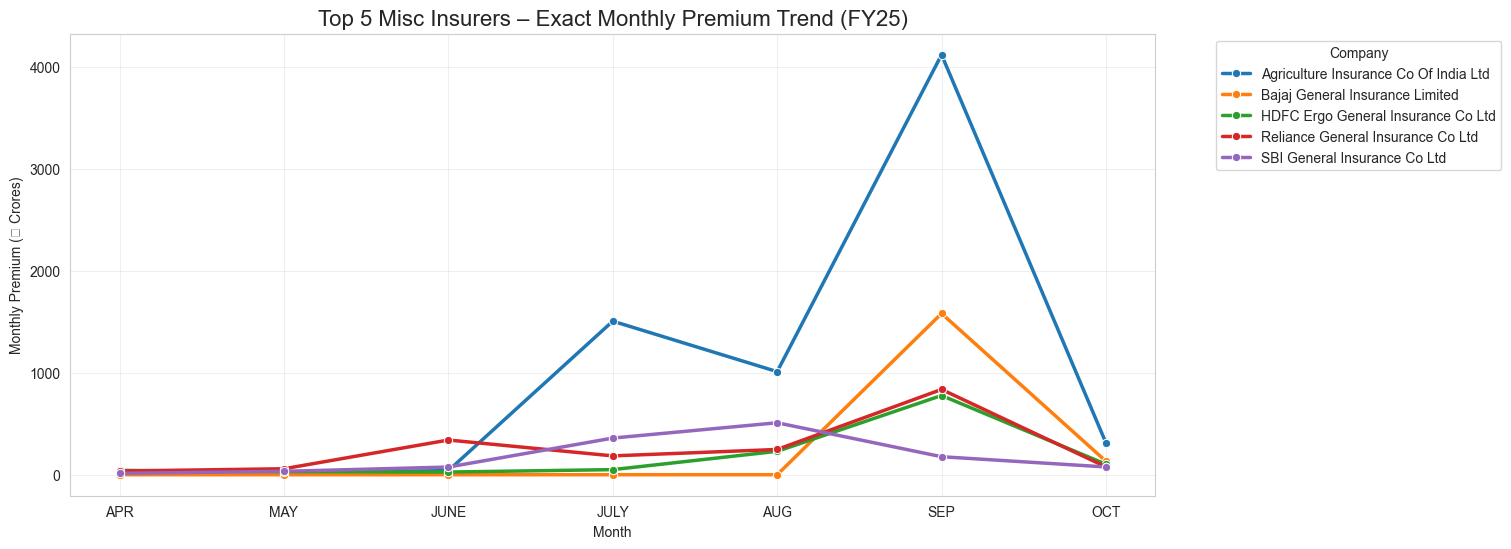

In [125]:
# Filter Misc only
misc_df = final_df[final_df["segment"] == "misc"].copy()

# Ensure month order
month_order = ["APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT"]
misc_df["ytd_upto_month"] = pd.Categorical(
    misc_df["ytd_upto_month"], categories=month_order, ordered=True
)

# Aggregate YTD at company level
misc_ytd = (
    misc_df
    .groupby(["financial_year", "company", "ytd_upto_month"])["premium_ytd"]
    .sum()
    .reset_index()
    .sort_values(["financial_year", "company", "ytd_upto_month"])
)

# Exact monthly = current − previous
misc_ytd["monthly_premium"] = (
    misc_ytd
    .groupby(["financial_year", "company"])["premium_ytd"]
    .diff()
)

# APR handling
misc_ytd.loc[
    misc_ytd["ytd_upto_month"] == "APR",
    "monthly_premium"
] = misc_ytd.loc[
    misc_ytd["ytd_upto_month"] == "APR",
    "premium_ytd"
]
misc_rank = (
    misc_ytd[misc_ytd["financial_year"] == "FY25"]
    .groupby("company")["monthly_premium"]
    .sum()
    .sort_values(ascending=False)
)

top5_misc = misc_rank.head(5)

display(top5_misc)
top5_misc_data = misc_ytd[
    (misc_ytd["financial_year"] == "FY25") &
    (misc_ytd["company"].isin(top5_misc.index))
]

plt.figure(figsize=(14,6))
sns.lineplot(
    data=top5_misc_data,
    x="ytd_upto_month",
    y="monthly_premium",
    hue="company",
    marker="o",
    linewidth=2.5
)

plt.title("Top 5 Misc Insurers – Exact Monthly Premium Trend (FY25)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.legend(title="Company", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


### Health Segment

In [126]:
# Filter Health only
health_df = final_df[final_df["segment"] == "health"].copy()

# Ensure month order
month_order = ["APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT"]
health_df["ytd_upto_month"] = pd.Categorical(
    health_df["ytd_upto_month"], categories=month_order, ordered=True
)

# Aggregate YTD at company level
health_ytd = (
    health_df
    .groupby(["financial_year", "company", "ytd_upto_month"])["premium_ytd"]
    .sum()
    .reset_index()
    .sort_values(["financial_year", "company", "ytd_upto_month"])
)

# Exact monthly premium = current - previous
health_ytd["monthly_premium"] = (
    health_ytd
    .groupby(["financial_year", "company"])["premium_ytd"]
    .diff()
)

# APR handling
health_ytd.loc[
    health_ytd["ytd_upto_month"] == "APR",
    "monthly_premium"
] = health_ytd.loc[
    health_ytd["ytd_upto_month"] == "APR",
    "premium_ytd"
]


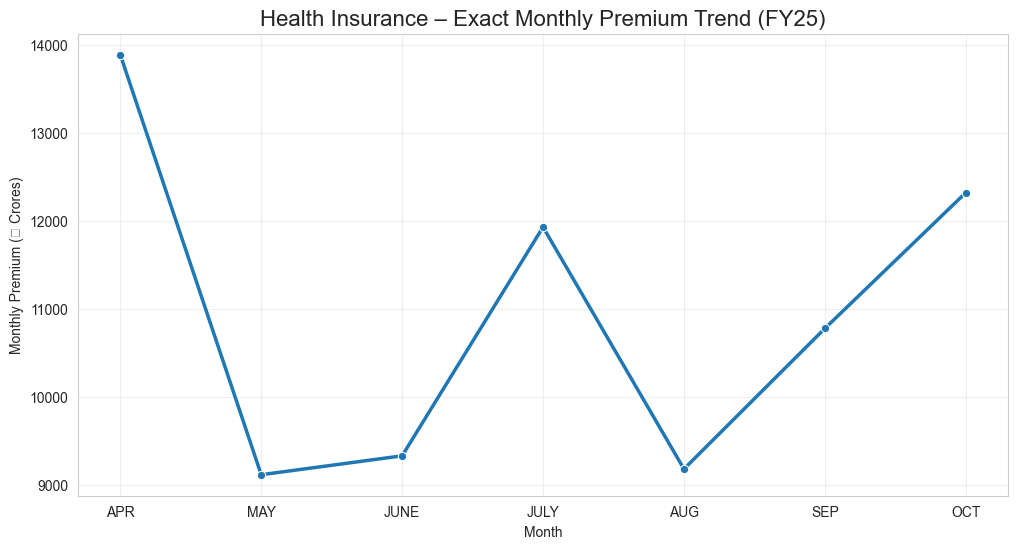

In [127]:
health_industry_monthly = (
    health_ytd[health_ytd["financial_year"] == "FY25"]
    .groupby("ytd_upto_month")["monthly_premium"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=health_industry_monthly,
    x="ytd_upto_month",
    y="monthly_premium",
    marker="o",
    linewidth=2.5
)

plt.title("Health Insurance – Exact Monthly Premium Trend (FY25)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.show()


In [128]:
health_company_rank = (
    health_ytd[health_ytd["financial_year"] == "FY25"]
    .groupby("company")["monthly_premium"]
    .sum()
    .sort_values(ascending=False)
)

top5_health = health_company_rank.head(5).index
bottom5_health = health_company_rank.tail(5).index

print("Top 5 Health Companies:", list(top5_health))
print("Bottom 5 Health Companies:", list(bottom5_health))


Top 5 Health Companies: ['The New India Assurance Co Ltd', 'Star Health & Allied Insurance Co Ltd', 'National Insurance Co Ltd', 'The Oriental Insurance Co Ltd', 'Care Health Insurance Ltd']
Bottom 5 Health Companies: ['Raheja QBE General Insurance Co Ltd', 'Kshema General insurance', 'Niva bupa health insurance company limited', 'Future Generali India Insurance Co Ltd', 'Bajaj Allianz General Insurance Co Ltd']


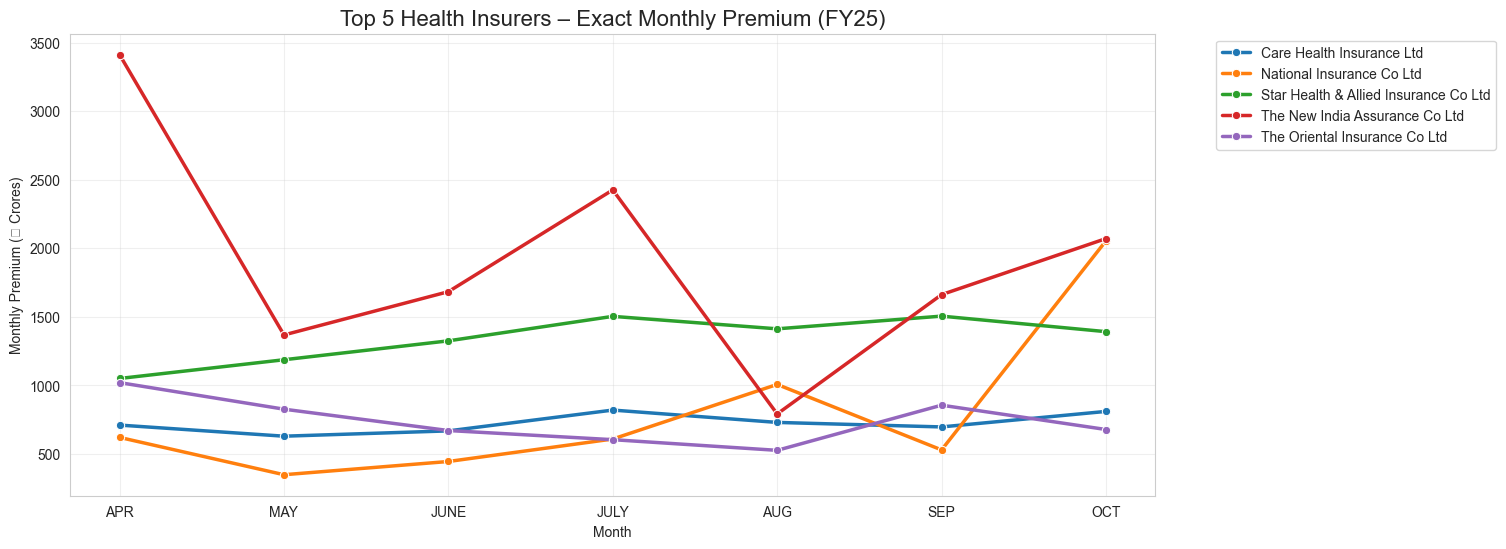

In [129]:
top5_health_data = health_ytd[
    (health_ytd["financial_year"] == "FY25") &
    (health_ytd["company"].isin(top5_health))
]

plt.figure(figsize=(14,6))
sns.lineplot(
    data=top5_health_data,
    x="ytd_upto_month",
    y="monthly_premium",
    hue="company",
    marker="o",
    linewidth=2.5
)

plt.title("Top 5 Health Insurers – Exact Monthly Premium (FY25)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Monthly Premium (₹ Crores)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [130]:
# Filter Health only
health_df = final_df[final_df["segment"] == "health"].copy()

# Ensure correct month order
month_order = ["APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT"]
health_df["ytd_upto_month"] = pd.Categorical(
    health_df["ytd_upto_month"], categories=month_order, ordered=True
)

# Aggregate YTD at company level
health_ytd = (
    health_df
    .groupby(["financial_year", "company", "ytd_upto_month"])["premium_ytd"]
    .sum()
    .reset_index()
    .sort_values(["financial_year", "company", "ytd_upto_month"])
)

# Exact monthly premium = current − previous
health_ytd["monthly_premium"] = (
    health_ytd
    .groupby(["financial_year", "company"])["premium_ytd"]
    .diff()
)

# APR handling
health_ytd.loc[
    health_ytd["ytd_upto_month"] == "APR",
    "monthly_premium"
] = health_ytd.loc[
    health_ytd["ytd_upto_month"] == "APR",
    "premium_ytd"
]
health_rank = (
    health_ytd[health_ytd["financial_year"] == "FY25"]
    .groupby("company")["monthly_premium"]
    .sum()
    .sort_values(ascending=False)
)

top10_health = health_rank.head(10)

display(top10_health)


company
The New India Assurance Co Ltd                13413.36
Star Health & Allied Insurance Co Ltd          9376.09
National Insurance Co Ltd                      5614.49
The Oriental Insurance Co Ltd                  5182.63
Care Health Insurance Ltd                      5066.14
ICICI Lombard General Insurance Co Ltd         4838.19
Bajaj General Insurance Limited                4362.67
United India Insurance Co Ltd                  4174.48
 Niva bupa health insurance company limited    4107.51
HDFC Ergo General Insurance Co Ltd             3377.15
Name: monthly_premium, dtype: float64

## 6. Competitive Landscape
Analysis of top players and market concentration.

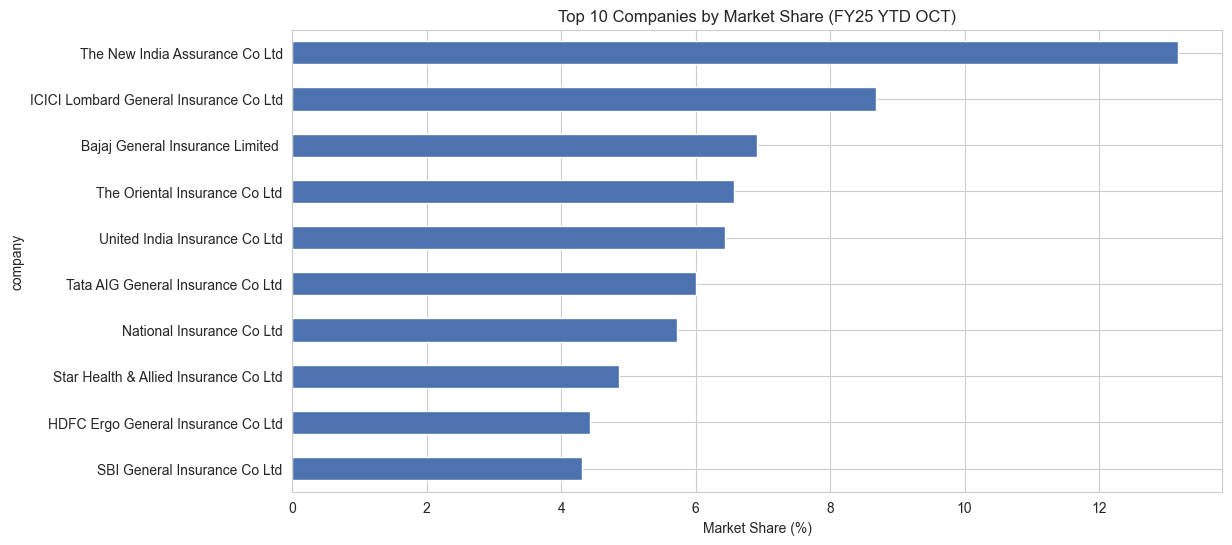

In [131]:
# Top Companies by Market Share (OCT FY25)
company_oct = (
    final_df[(final_df["financial_year"]=="FY25") & (final_df["ytd_upto_month"]=="OCT")]
    .groupby("company")["premium_ytd"]
    .sum()
    .sort_values(ascending=False)
)

company_share = company_oct / company_oct.sum() * 100
top_10 = company_share.head(10)

plt.figure(figsize=(12,6))
top_10.sort_values().plot(kind="barh", color="#4c72b0")
plt.title("Top 10 Companies by Market Share (FY25 YTD OCT)")
plt.xlabel("Market Share (%)")
plt.show()

In [132]:
file_path = 'segment_october_2025.xlsx'

health_df_raw = pd.read_excel(file_path, sheet_name='Health Portfolio')
health_df_raw.columns = ['company', 'health_retail', 'health_group', 'health_govt', 'year']
health_df = health_df_raw[health_df_raw['year'] == 'FY25'].copy()
health_df = health_df.drop('year', axis=1)
health_df['health_retail'] = health_df['health_retail'].fillna(0)
health_df['health_group'] = health_df['health_group'].fillna(0)
health_df['health_govt'] = health_df['health_govt'].fillna(0)

health_df['health_total'] = health_df['health_retail'] + health_df['health_group'] + health_df['health_govt']
health_df = health_df[health_df['health_total'] > 1].copy()
health_df['retail_share'] = (health_df['health_retail'] / health_df['health_total'] * 100).round(2)
health_df['group_share'] = (health_df['health_group'] / health_df['health_total'] * 100).round(2)
health_df['govt_share'] = (health_df['health_govt'] / health_df['health_total'] * 100).round(2)

health_df.loc[health_df['health_total'] == 0, ['retail_share', 'group_share', 'govt_share']] = 0

def classify_health_strategy(row):
    if row['retail_share'] > 60:
        return 'Retail-First'
    elif row['group_share'] > 60:
        return 'Group-Heavy'
    elif row['govt_share'] > 25:
        return 'Govt-Exposed'
    else:
        return 'Balanced'

health_df['strategy_type'] = health_df.apply(classify_health_strategy, axis=1)

misc_df_raw = pd.read_excel(file_path, sheet_name='Miscellaneous portfolio')
misc_df_raw.columns = ['company', 'crop_insurance', 'credit_guarantee', 'other_misc', 'year']
misc_df = misc_df_raw[misc_df_raw['year'] == 'FY25'].copy()
misc_df = misc_df.drop('year', axis=1)
misc_df['crop_insurance'] = misc_df['crop_insurance'].fillna(0)
misc_df['credit_guarantee'] = misc_df['credit_guarantee'].fillna(0)
misc_df['other_misc'] = misc_df['other_misc'].fillna(0)
misc_df['misc_total'] = misc_df['crop_insurance'] + misc_df['credit_guarantee'] + misc_df['other_misc']
misc_df = misc_df[misc_df['misc_total'] > 1].copy()

misc_df['crop_concentration'] = (misc_df['crop_insurance'] / misc_df['misc_total'] * 100).round(2)
misc_df['credit_dependence'] = (misc_df['credit_guarantee'] / misc_df['misc_total'] * 100).round(2)
misc_df['other_share'] = (misc_df['other_misc'] / misc_df['misc_total'] * 100).round(2)

misc_df.loc[misc_df['misc_total'] == 0, ['crop_concentration', 'credit_dependence', 'other_share']] = 0

def classify_misc_risk(row):
    if row['crop_concentration'] > 80:
        return 'High-Crop-Risk'
    elif row['credit_dependence'] > 80:
        return 'Credit-Specialist'
    elif row['other_share'] > 60:
        return 'Diversified-Misc'
    else:
        return 'Mixed-Misc'

misc_df['misc_risk_type'] = misc_df.apply(classify_misc_risk, axis=1)

health_df['company'] = health_df['company'].str.strip()
misc_df['company'] = misc_df['company'].str.strip()

combined_df = pd.merge(
    health_df[['company', 'health_total', 'retail_share', 'govt_share', 'strategy_type']],
    misc_df[['company', 'misc_total', 'crop_concentration', 'credit_dependence', 'misc_risk_type', 'crop_insurance']],
    on='company',
    how='outer'
)

combined_df = combined_df.fillna(0)

combined_df['total_govt_exposure'] = combined_df['govt_share'] + combined_df['crop_concentration']

def quality_classification(row):
    if row['retail_share'] > 60 and row['crop_concentration'] < 20:
        return ' High-Quality'
    elif row['retail_share'] < 30 and row['crop_concentration'] > 60:
        return ' High-Risk'
    else:
        return ' Mixed'

combined_df['quality_tier'] = combined_df.apply(quality_classification, axis=1)

HEALTH INSURANCE STRATEGY CLASSIFICATION (FY25)
               Total Premium (₹ Cr)  Number of Companies
strategy_type                                           
Balanced                    3206.09                    3
Govt-Exposed                4241.16                    1
Group-Heavy                46247.25                   20
Retail-First               21908.76                    7



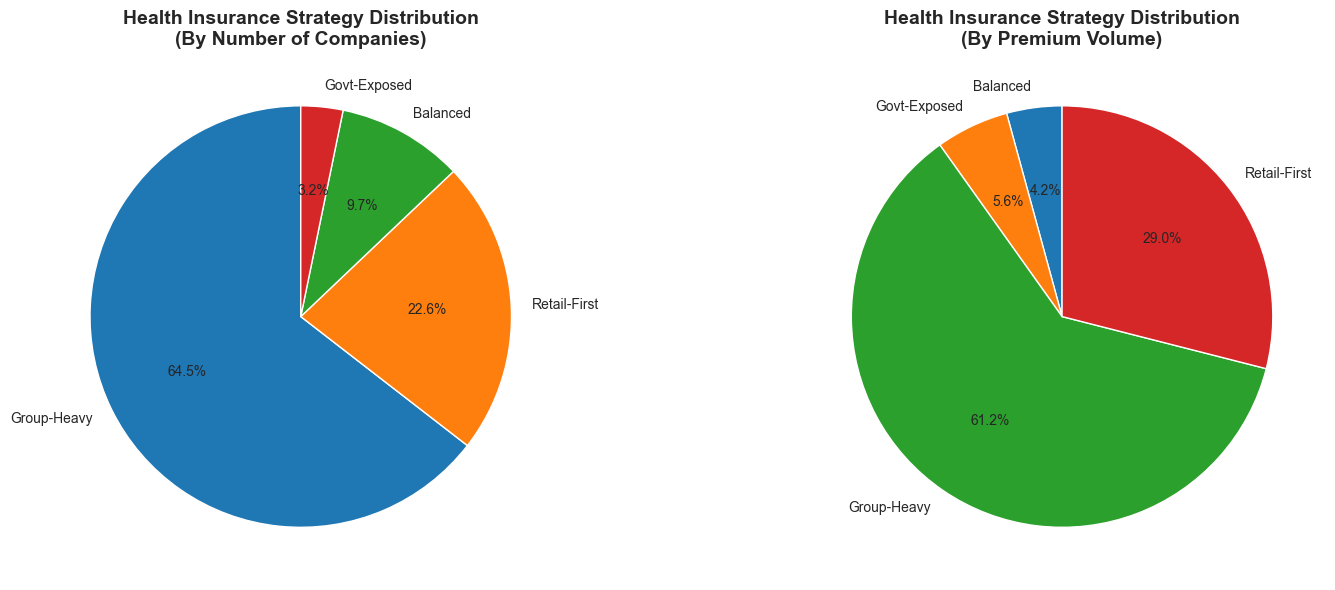

In [133]:
print("="*80)
print("HEALTH INSURANCE STRATEGY CLASSIFICATION (FY25)")
print("="*80)

strategy_summary = health_df.groupby('strategy_type').agg({
    'health_total': ['sum', 'count']
}).round(2)
strategy_summary.columns = ['Total Premium (₹ Cr)', 'Number of Companies']
print(strategy_summary)
print()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

strategy_counts = health_df['strategy_type'].value_counts()
axes[0].pie(strategy_counts.values, labels=strategy_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Health Insurance Strategy Distribution\n(By Number of Companies)', fontsize=14, fontweight='bold')

strategy_premium = health_df.groupby('strategy_type')['health_total'].sum()
axes[1].pie(strategy_premium.values, labels=strategy_premium.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Health Insurance Strategy Distribution\n(By Premium Volume)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

TOP 10 RETAIL FIRST HEALTH INSURERS (FY25)
                                   company  health_retail  retail_share  health_total
     Star Health & Allied Insurance Co Ltd        8957.79         95.60       9369.96
                 Care Health Insurance Ltd        3225.32         64.62       4991.16
Niva bupa health insurance company limited        2831.67         69.11       4097.61
        HDFC Ergo General Insurance Co Ltd        2436.46         73.00       3337.53
            Navi General Insurance Co. Ltd          36.39         62.70         58.04
       Galaxy Health Insurance Company Ltd          30.78         64.39         47.80
          Shriram General Insurance Co Ltd           4.48         67.27          6.66



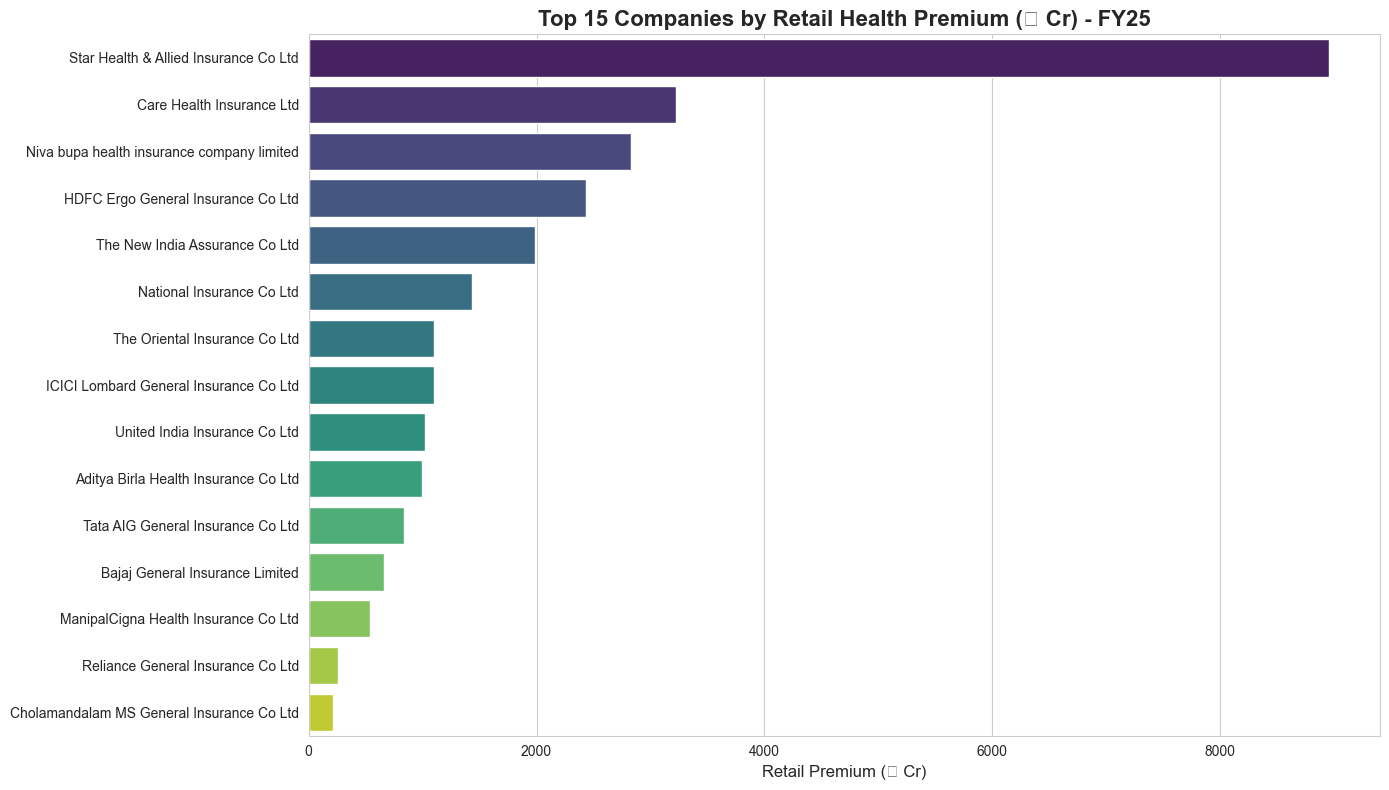

In [134]:
print("TOP 10 RETAIL FIRST HEALTH INSURERS (FY25)")
print("="*80)

retail_first = health_df[health_df['strategy_type'] == 'Retail-First'].sort_values('health_retail', ascending=False).head(10)
print(retail_first[['company', 'health_retail', 'retail_share', 'health_total']].to_string(index=False))
print()

plt.figure(figsize=(14, 8))
top_retail = health_df.nlargest(15, 'health_retail')
sns.barplot(data=top_retail, y='company', x='health_retail', palette='viridis')
plt.title('Top 15 Companies by Retail Health Premium (₹ Cr) - FY25', fontsize=16, fontweight='bold')
plt.xlabel('Retail Premium (₹ Cr)', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()


MISC SEGMENT RISK CLASSIFICATION (FY25)
                   Total Premium (₹ Cr)  Number of Companies
misc_risk_type                                              
Credit-Specialist                777.34                    1
Diversified-Misc                2518.40                   13
High-Crop-Risk                 10855.08                    5
Mixed-Misc                      6270.86                    6



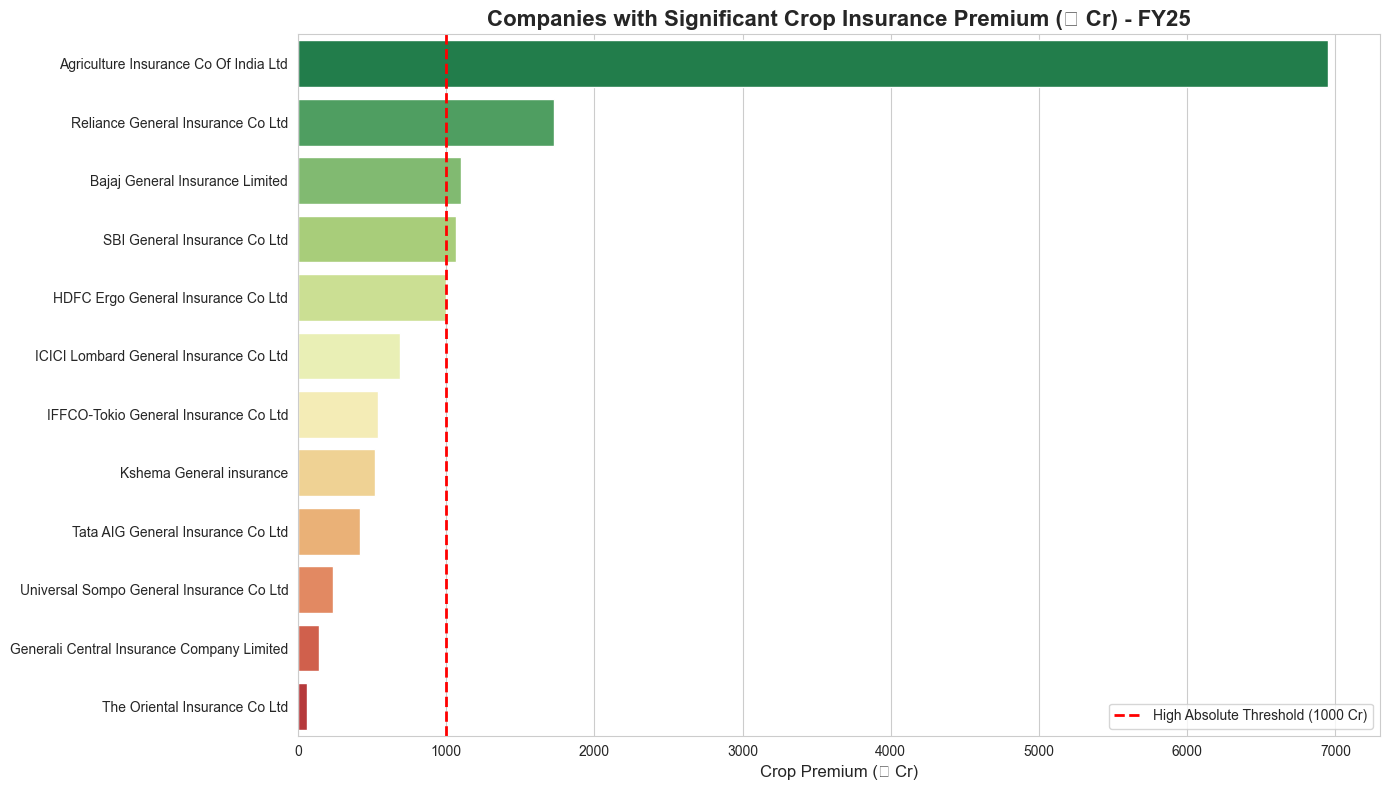

In [135]:
print("="*80)
print("MISC SEGMENT RISK CLASSIFICATION (FY25)")
print("="*80)

misc_risk_summary = misc_df.groupby('misc_risk_type').agg({
    'misc_total': ['sum', 'count']
}).round(2)
misc_risk_summary.columns = ['Total Premium (₹ Cr)', 'Number of Companies']
print(misc_risk_summary)
print()

plt.figure(figsize=(14, 8))
high_crop = misc_df[misc_df['crop_concentration'] > 10].sort_values('crop_insurance', ascending=False)
sns.barplot(data=high_crop, y='company', x='crop_insurance', palette='RdYlGn_r')
plt.title('Companies with Significant Crop Insurance Premium (₹ Cr) - FY25', fontsize=16, fontweight='bold')
plt.xlabel('Crop Premium (₹ Cr)', fontsize=12)
plt.ylabel('')
plt.axvline(1000, color='red', linestyle='--', linewidth=2, label='High Absolute Threshold (1000 Cr)')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Conclusion

The FY25 (April–October) General Insurance data shows that industry growth is no longer uniform. The market is splitting between insurers focused on expanding premium volumes and those focused on improving portfolio quality. These two approaches carry very different risk and profitability outcomes.

### 1. Volume Growth Is Increasing Risk Exposure
Public sector insurers are driving growth by expanding in Group Health, Motor Third Party, and Crop Insurance. This increases premium scale but also raises exposure to medical cost inflation, long tail claims development, and weather dependent outcomes. These segments operate with structurally lower margins, which puts pressure on underwriting results.

### 2. Private Insurers Are Protecting Portfolio Quality
Slower growth among private insurers reflects a deliberate shift in strategy. Several large private players have reduced participation in bulk and government linked business where pricing control is limited. Instead, they are focusing on Retail Health and Motor Own Damage, which offer better risk selection, pricing flexibility, and more stable loss experience. This has reduced premium growth but improved overall portfolio quality.

### 3. Tata AIG Is an Exception
Tata AIG is one of the few large insurers that has grown while maintaining portfolio quality. Its business mix is weighted toward Retail Health and Motor Own Damage, with controlled exposure to volatile segments. This makes its growth more sustainable than peers following a volume led approach.

### 4. Health Insurance Has Two Distinct Models
The Health segment has split into two clear models. Retail focused insurers operate with better pricing control and more stable margins. Group focused portfolios depend on high volumes but face higher claims volatility and pricing pressure. This gap is likely to widen as medical costs continue to rise.

### 5. Crop Insurance Carries Hidden Balance Sheet Risk
Crop Insurance remains highly sensitive to monsoon outcomes and claim settlement timelines. Insurers with high concentration in this segment face earnings volatility that is not visible in premium growth figures alone.

### Takeaway
Industry growth continues, but outcomes now depend on portfolio mix and underwriting discipline rather than premium expansion. Insurers focused on risk control and margin stability are better positioned than those prioritizing volume.
